# Set-up

### Imports

In [1]:
import math
import random
import json
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 18 # set font size
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
from torch.nn import MSELoss, BCEWithLogitsLoss, CrossEntropyLoss

from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import TextClassificationPipeline
from datasets import Dataset, DatasetDict, Features, ClassLabel, Value

from transformers import BertConfig
from transformers.models.bert.modeling_bert import BertModel, BertPreTrainedModel
from transformers.modeling_outputs import SequenceClassifierOutput

device = torch.device("cpu")


In [2]:
# Set folders
dir_models =   Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\models')
dir_data =     Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\data')
dir_diagrams = Path(r'C:\Users\rldek\Mijn Drive (TiU)\Thesis\Code\thesis-msc-data-science\diagrams')

In [ ]:
# # code for Google Colab

# from google.colab import drive
# drive.mount('/content/drive')
# cd "drive/My Drive/Thesis/Code/thesis-msc-data-science"
# dir_models = ..... (relative path)

# dir_data = ....  (relative path)
# pip install datasets

### Model configs

In [3]:
experiments = {
    'bert_base_full': { # Base BERT model on full original dataset, reproduced from Luo et al.
        'output_name': 'bert_base_full',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },   
    'bert_base_reduc': { # Base BERT model on reduced dataset (corresponding to samples available in augm. dataset)
        'output_name': 'bert_base_reduc',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'reduc',
        'context_type': None,
        'custom_pooling': False
    },  
    'bert_aug_before': { # Model on augmented dataset, using '[CLS] context [SEP] sentence [SEP]' structure
        'output_name': 'bert_aug_before',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug',
        'context_type': 'before',    
        'custom_pooling': False    
    },  
    'bert_aug_after': { # Model on augmented dataset, using '[CLS] sentence [SEP] context [SEP]' structure
        'output_name': 'bert_aug_after',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug',
        'context_type': 'after',
        'custom_pooling': False
    },   
    'bert_aug_full': { # Model on augmented dataset, using '[CLS] context + sentence + context [SEP]' structure
        'output_name': 'bert_aug_full',
        'ckpt': "google-bert/bert-base-uncased",
        'dataset_type': 'aug',
        'context_type': 'full',
        'custom_pooling': True
    },
    'droberta_base': { # Base distilRoBERTa model to compare against Climate-model
        'output_name': 'droberta_base',
        'ckpt': "distilbert/distilroberta-base",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },      
    'droberta_climate': { # Climate model on full original dataset
        'output_name': 'droberta_climate',
        'ckpt': "climatebert/distilroberta-base-climate-f",
        'dataset_type': 'orig',
        'context_type': None,
        'custom_pooling': False
    },
}

### Global definitions and functions

In [4]:
# Define label dictionary for HuggingFace model config.json
label_names = ['disagree', 'agree', 'neutral']
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

def total_steps(experiment: dict) -> int:
    """Calculate total n steps of trainig config, based on n_epochs, n_samples and batch_size."""
    n_samples = len(experiment['dataset_enc']['train'])
    n_epochs = 7
    batch_size = 16

    steps_per_epoch = math.ceil(n_samples / batch_size)
    total_steps = steps_per_epoch * n_epochs

    return total_steps

def set_deterministic(seed:int) -> None:
    """Set random seed and disable deterministic algorithms for reproducability of results"""
    random.seed(int(seed))
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(mode=True) # mode=True -> throw runtime error if deterministic alternative not available
   
def get_y_pred(model_name:str, folder_path:str, subset:str = 'test'):
    """Return predicted y values on set for given model_name in given folder_path."""
    
    model = AutoModelForSequenceClassification.from_pretrained(folder_path, num_labels=3)
    tokenizer = AutoTokenizer.from_pretrained(folder_path)

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer)
    preds = pipe(experiments[model_name]['dataset_enc'][subset]['sentence'])

    return np.array([label2id[pred['label']] for pred in preds])

def get_y_true(model_name:str, subset:str = 'test'):
    """Return true y values on set for given model_name"""

    return np.array(experiments[model_name]['dataset_enc'][subset]['label'])

def get_model_last_ckpt_path(model_name:str):
    experiment = experiments[model_name]
    last_ckpt_path = dir_models / experiment['output_name'] / f'checkpoint-{total_steps(experiment)}'
    if not last_ckpt_path.exists():
        raise FileNotFoundError("Folder does not exist. Perhaps the location is incorrect, or the model was not trained, or the checkpoint-step number is incorrect?")
    return last_ckpt_path

def get_model_best_ckpt_path(model_name:str):

    log = get_model_log(model_name)

    best_ckpt_path = dir_models / Path(log['best_model_checkpoint'].replace('models/', ''))
    if not best_ckpt_path.exists():
        raise FileNotFoundError("Folder does not exist.")
    return best_ckpt_path

def get_model_log(model_name: str) -> dict:
    experiment = experiments[model_name]

    last_ckpt_path = get_model_last_ckpt_path(model_name)

    log_path = last_ckpt_path / 'trainer_state.json'
    if not log_path.exists():
        raise FileNotFoundError("'trainer_state.json' not found.")

    with open(log_path) as file:
        log = json.load(file)

    return log

def make_conf_matrix(y_true,
                      y_pred,
                      labels: list,
                      save: bool = False,
                      folderpath: str = dir_diagrams,
                      filename: str = 'conf_matrix'):
    
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True) 
        plt.tight_layout()
        plt.savefig(folderpath / f'{filename}.png', dpi=600)

def make_classification_report(y_true,
                               y_pred,
                               labels: list,
                               save: bool = False,
                               folderpath: str = dir_diagrams,
                               filename: str = 'classification_report'):
    
    print(classification_report(y_true, y_pred, target_names=labels))

    if save:
        if not folderpath.exists():
            folderpath.mkdir(parents=True, exist_ok=True) 
        pd.DataFrame(classification_report(y_true, y_pred, target_names=labels, output_dict=True)).to_excel(folderpath / f'{filename}.xlsx')


### Datasets

In [5]:
data_file = dir_data / 'articles.pkl'

# Import and modify pandas dataframe
data_df = pd.read_pickle(data_file)

# Construct multiple context types
def get_context(row: pd.Series, context_type: str):
    if context_type == 'context_before':
        context = f"{row['title']} : {row['sent-5']} {row['sent-4']} {row['sent-3']} {row['sent-2']} {row['sent-1']} {row['sent0']}"
        return context
    elif context_type == 'context_after':
        context =  f"{row['sent0']} {row['sent+1']} {row['sent+2']} {row['sent+3']} {row['sent+4']} {row['sent+5']}"
        return context
    else:
        return ''

for context_type in ['context_before', 'context_after']:
    data_df[context_type] = data_df.apply(lambda row: get_context(row, context_type), axis=1)

# Split train-test
data_df_train = data_df[data_df['in_held_out_test'] == False].reset_index(drop=True)
data_df_test = data_df[data_df['in_held_out_test'] == True].reset_index(drop=True)  # test_set defined by Luo et al. and used for human baseline

# Select reduced size dataset (based on available samples for augmented dataset)
data_df_train_reduc = data_df_train[data_df_train['ok'] == True].reset_index(drop=True)
data_df_test_reduc = data_df_test[data_df_test['ok'] == True].reset_index(drop=True)

# Change dataframe to Transformers dataset type

# Define dataset features
features_dict = {
    'orig': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'reduc': Features({'sentence': Value('string'),
                      'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
    'aug': Features({'sentence': Value('string'),
                          'context_before': Value('string'),
                          'context_after': Value('string'),
                          'label': ClassLabel(names=["disagree", "agree", "neutral"])}),
}

# Create dataset variants
datasets = {
    'orig': DatasetDict({
        'train': Dataset.from_pandas(data_df_train[['label', 'sentence']], features=features_dict['orig']),
        'test':  Dataset.from_pandas(data_df_test[['label', 'sentence']], features=features_dict['orig'])
    }),
    'reduc': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'sentence']], features=features_dict['reduc']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'sentence']], features=features_dict['reduc'])
    }),
    'aug': DatasetDict({
        'train': Dataset.from_pandas(data_df_train_reduc[['label', 'context_before', 'context_after', 'sentence']], features=features_dict['aug']),
        'test':  Dataset.from_pandas(data_df_test_reduc[['label', 'context_before', 'context_after', 'sentence']], features=features_dict['aug'])
    }),
}

In [12]:
# This comparison verifies that the proportion of test samples in the reduced dataset is similar to the full dataset
print(data_df['in_held_out_test'].value_counts(normalize=True))
print()
print(data_df[data_df['ok'] == True]['in_held_out_test'].value_counts(normalize=True))

in_held_out_test
False    0.902439
True     0.097561
Name: proportion, dtype: float64

in_held_out_test
False    0.900592
True     0.099408
Name: proportion, dtype: float64


### Tokenization

In [6]:
# Define tokenizer variants (for incorporating context)
def tokenize(batch, tokenizer, context_type=None):
    if context_type == None:
        return tokenizer(batch["sentence"], padding=True, truncation=True)
    elif context_type =='before':
        return tokenizer(text=batch["context_before"], text_pair=batch["sentence"], padding=True, truncation=True)
    elif context_type == 'after':
        return tokenizer(text=batch["sentence"], text_pair=batch["context_after"], padding=True, truncation=True)
    elif context_type == 'full':
        # make full context sequence
        full_strings = [bef + main + aft for bef, main, aft in zip(batch['context_before'], batch['sentence'], batch['context_after'])]

        # get char. indices of main sentence in full sequence
        start_char_indices = [len(bef) for bef in batch['context_before']]
        end_char_indices =   [len(bef)+len(main) for bef, main in zip(batch['context_before'], batch['sentence'])]

        # tokenize
        tokenized_output = tokenizer(text=full_strings, padding=True, truncation=True, return_offsets_mapping=True)

        # get token indices of main sentence in full sequence
        main_sent_masks = [
            [1 if token_start >= sent_start and token_end <= sent_end else 0 for token_start, token_end in offsets]
            for offsets, sent_start, sent_end in zip(tokenized_output['offset_mapping'], start_char_indices, end_char_indices)
        ]

        return {
             'input_ids': tokenized_output['input_ids'],
             'token_type_ids': tokenized_output['token_type_ids'],
             'attention_mask': tokenized_output['attention_mask'],
             'main_sent_mask': main_sent_masks 
        }

for model_name, experiment in experiments.items():

    # Get tokenizers
    experiments[model_name]['tokenizer'] = AutoTokenizer.from_pretrained(experiment['ckpt'])

    # Tokenize
    experiments[model_name]['dataset_enc'] = datasets[experiment['dataset_type']].map(lambda batch: tokenize(batch, experiment['tokenizer'], experiment['context_type']), batched=True, batch_size=None)

    # Encode data in PyTorch types
    experiments[model_name]['dataset_enc'].set_format("torch", output_all_columns=True)

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

##### Verify that main sentence can be correctly retrieved from tokenized sentence

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

sample = experiments['bert_aug_full']['dataset_enc']['train'][30]

seq = [tok for tok, m in zip(sample['input_ids'], sample['main_sent_mask']) if m == 1]

print(sample['sentence'])
print(tokenizer.decode(seq))

The West Antarctic Ice Sheet is going to go unstable.
the west antarctic ice sheet is going to go unstable.


# WIP: custom BERT model with pooled output hidden states

### Get hidden tokens of main sentence

In [113]:
from transformers import AutoModel

model_bert = AutoModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Data
batch = {
    'context_before': ["This is before.", "This is before."],
    'sentence': ["Hello, world!", "Hello, beautiful, strange, stupid, ambiguous, empty, world!"],
    'context_after': ["This is after.", "This is after."]
}

# tokenize
tokenized = Dataset.from_dict(tokenize(batch, tokenizer, context_type='full')).with_format("torch")

# run through model
inputs = {'input_ids': tokenized['input_ids'],
          'token_type_ids': tokenized['token_type_ids'],
          'attention_mask': tokenized['attention_mask']}
outputs = model_bert(**inputs)

all_hidden_states = outputs[2] # retrieve 'hidden_states' key  (see https://github.com/huggingface/transformers/issues/1827 )
embedding_hidden_states = all_hidden_states[0]
attention_hidden_states = all_hidden_states[1:]  # retrieve hidden states at all 12 layers of model


h11 = attention_hidden_states[-2] # retrieve hidden states of second last layer (11 of 12). This has size(batch_size, seq. length, hidden_size) e.g. (2, 24, 768)

# Perform pooling (see https://bert-as-service.readthedocs.io/en/latest/section/faq.html#are-you-suggesting-using-bert-without-fine-tuning)

m = tokenized['main_sent_mask']

# result of output sequence after applying mask 
mul_mask = h11 * m.unsqueeze(-1)

         # sum over tokens   # amount of tokens in mask                    # prevent divide-by-0 error
pooled = torch.sum(mul_mask, dim=1) / (torch.sum(m, dim=1, keepdim=True) + 1e-10)
# output size(batch_size, hidden_size), just like the default HF BERT pooled_output size

# Pass through MLP+tanh (just like default [CLS] pooled output by Devlin et al.)


c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Custom model definition

In [8]:
class CustomBertPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:

        # pool tokens together (code originally from Bert-as-Service)
        mul_mask = hidden_states * mask.unsqueeze(-1)
        pooled_output = torch.sum(mul_mask, dim = 1) / (torch.sum(mask, dim = 1, keepdim = True) + 1e-10)

        # pass through nn
        pooled_output = self.dense(pooled_output)
        pooled_output = self.activation(pooled_output)
        return pooled_output

# TODO: customize the below code!!! (copied straight from original source)
class CustomBertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)

        # CUSTOM: we don't use the pooled_output from BertModel (which exclusively uses the [CLS]-token), but define our own pooler. BertModel remains unmodified
        self.pooler = CustomBertPooler(config)

        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: torch.Tensor = None,
        attention_mask: torch.Tensor = None,
        token_type_ids: torch.Tensor = None,
        position_ids: torch.Tensor = None,
        head_mask: torch.Tensor = None,
        inputs_embeds: torch.Tensor = None,
        labels: torch.Tensor = None,
        main_sent_mask: torch.Tensor = None,  # for pooling only the main-sentence tokens
        output_attentions: bool = None,
        output_hidden_states: bool = None,
        return_dict: bool = None,
    ):

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # CUSTOM: obtain average-pooled representation of main-sentence hidden state tokens from second last layer (-2) https://bert-as-service.readthedocs.io/en/latest/section/faq.html#are-you-suggesting-using-bert-without-fine-tuning 
        pooled_output = self.pooler(outputs['hidden_states'][-2], main_sent_mask)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Training

##### Set-up

In [10]:
def compute_metrics(pred) -> dict:
    """Get metrics for evaluation of Transformers Trainer"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return { "accuracy": accuracy_score(labels, preds),
             "f1": f1_score(labels, preds, average="macro")}

def get_training_args(output_name: str) -> TrainingArguments:
    """ Get Transformers TrainingArgs object. 'output_name' is used for output_dir."""
    return TrainingArguments(
        output_dir = dir_models / output_name,
        num_train_epochs = 7,
        learning_rate = 2e-5,
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        adam_epsilon = 1e-6,
        warmup_steps = 0,
        evaluation_strategy = 'epoch',
        logging_strategy = 'epoch',
        save_strategy = 'epoch',
        metric_for_best_model = 'f1',
        load_best_model_at_end = True)

def init_trainer(model, args: TrainingArguments, dataset: DatasetDict, tokenizer) -> Trainer:
    """Initialize Transformers Trainer object"""
    return Trainer(model=model, args=args,
                   compute_metrics=compute_metrics,
                   train_dataset = dataset['train'],
                   eval_dataset = dataset['test'],
                   tokenizer=tokenizer)

def train_model(model_name: str, output_name: str = None) -> None:
    """Train model according to specified configuration in 'models' dict."""
    experiment = experiments[model_name]

    experiment['config'] = AutoConfig.from_pretrained(experiment['ckpt'], output_hidden_states=True, num_labels=3, id2label=id2label, label2id=label2id)

    if experiment['custom_pooling']:
        experiment['model'] = CustomBertForSequenceClassification.from_pretrained(experiment['ckpt'], config=experiment['config']).to(device)
    else:
        experiment['model'] = AutoModelForSequenceClassification.from_pretrained(experiment['ckpt'], config=experiment['config']).to(device)

    experiment['train_args'] = get_training_args(output_name or experiment['output_name'])
    experiment['trainer'] = init_trainer(experiment['model'], experiment['train_args'], experiment['dataset_enc'], experiment['tokenizer'])
    experiment['trainer'].train()

##### Train all model configurations

In [ ]:
for model_name in experiments.keys():
    train_model(model_name)

##### Train individually

###### BERT base full

In [ ]:
train_model('bert_base_full')

###### BERT base reduced

In [ ]:
train_model('bert_base_reduc')

###### Augmented before

In [ ]:
train_model('bert_aug_before')

###### Augmented after

In [ ]:
train_model('bert_aug_after')

###### Augmented full

In [11]:
train_model('bert_aug_full')

Some weights of CustomBertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/672 [00:00<?, ?it/s]

KeyboardInterrupt: 

###### DistilRoBERTa base

In [ ]:
train_model('droberta_base')

###### BERT base full

In [ ]:
train_model('droberta_climate')

###### DRoBERTa Climate

In [ ]:
train_model('droberta_climate')

In [ ]:
experiment = experiments['droberta_climate']

experiment['model'] = AutoModelForSequenceClassification.from_pretrained(experiment['ckpt'], num_labels=3).to(device)
experiment['train_args'] = get_training_args(experiment['output_name'])
experiment['trainer'] = init_trainer(experiment['model'], experiment['train_args'], experiment['dataset_enc'], experiment['tokenizer'])
experiment['trainer'].train()

# on may 15th, best epoch was 5 (checkpoint-580)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.939500,0.757471,0.625000,0.598745
2,0.648500,0.628923,0.745000,0.742921
3,0.467800,0.622958,0.760000,0.759140
4,0.331200,0.646882,0.760000,0.759107
5,0.226400,0.702919,0.770000,0.769499
6,0.167800,0.784633,0.765000,0.763519
7,0.123700,0.803689,0.760000,0.758683


### Test reproducability of deterministic mode

##### Train two models which should be identical

In [ ]:
seed = 10

for rep in ['a', 'b']:

    set_deterministic(seed)    

    output_name = f"reprod_test_{rep}"

    train_model('bert_base_full', f"reprod_test_{rep}")   

##### Evaluate if the models have equal parameters

In [30]:
experiment = experiments['bert_base_full']

folder_path_a = dir_models / 'reprod_test_a' / f'checkpoint-{total_steps(experiment)}'
folder_path_b = dir_models / 'reprod_test_b' / f'checkpoint-{total_steps(experiment)}'

if not folder_path_a.exists() or not folder_path_b.exists():
    raise FileNotFoundError("At least one folder does not exist. Do the models exist in that folder?")

model_a = AutoModelForSequenceClassification.from_pretrained(folder_path_a, num_labels=3)
model_b = AutoModelForSequenceClassification.from_pretrained(folder_path_b, num_labels=3)

equal_params = str(model_a.state_dict()) == str(model_b.state_dict())

if equal_params:
    print("The two independently trained models are equal. ✅")
else:
    print("The two independently trained models are NOT equal. ❗")

The two independently trained models are equal. ✅


### Find best seed for base model

##### Create seeds

In [140]:
start_seed = 42
n_seeds = 5
first_seed = 0
last_seed = 4

np.random.seed(start_seed)
seeds = np.random.randint(low=0, high=2**32 - 1, size=n_seeds, dtype=np.uint32)

##### Train model for every seed

In [37]:
for seed in seeds:
    set_deterministic(seed)

    #train_model('bert_base_full', f"bert_base_full_seed_{seed}")
    print(f"bert_base_full_seed_{seed}")


bert_base_full_seed_1608637542
bert_base_full_seed_3421126067
bert_base_full_seed_4083286876
bert_base_full_seed_787846414
bert_base_full_seed_3143890026


##### Evaluate models and select best one

In [39]:
model_names = [ f"bert_base_full_seed_{seed}" for seed in seeds]


['bert_base_full_seed_1608637542',
 'bert_base_full_seed_3421126067',
 'bert_base_full_seed_4083286876',
 'bert_base_full_seed_787846414',
 'bert_base_full_seed_3143890026']

# Evaluation

In [7]:
# Specify model
model_name = 'droberta_base'

In [8]:
# Find path of last checkpoint
last_ckpt_path = get_model_last_ckpt_path(model_name)

# Retrieve log
log = get_model_log(model_name)

# Find path of best checkpoint (according to macro-averaged F1)
best_ckpt_path = get_model_best_ckpt_path(model_name)

In [9]:
y_pred = get_y_pred(model_name, best_ckpt_path)
y_true = get_y_true(model_name)
labels = list(label2id.keys())

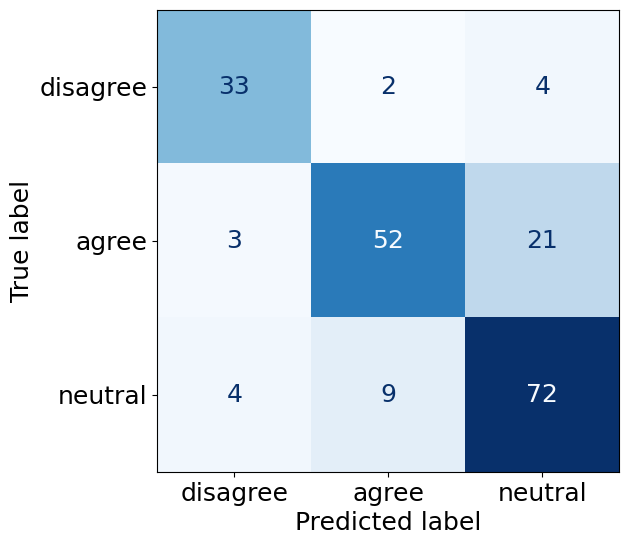

In [31]:
my_fig = make_conf_matrix(y_true, y_pred, labels, model_name, save=False)

In [47]:
make_classification_report(y_true, y_pred, labels, save=True, folder= dir_diagrams / 'evaluation', filename='class_report')

              precision    recall  f1-score   support

    disagree       0.82      0.85      0.84        39
       agree       0.83      0.68      0.75        76
     neutral       0.74      0.85      0.79        85

    accuracy                           0.79       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.79      0.79      0.78       200



In [12]:
def make_loss_per_epoch(log: dict):
    

In [17]:
def get_log_metrics(log: dict) -> dict:
    '''Obtain metrics from log file created during training model'''
    log_metrics = {}
    for metric in ['eval_f1', 'eval_accuracy', 'eval_loss', 'loss']:
        log_metrics[metric] = {entry['epoch']: entry[metric] for entry in log['log_history'] if metric in entry}

    return log_metrics

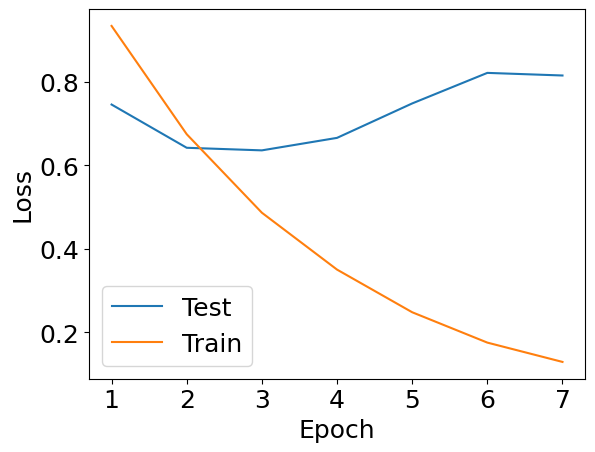

In [37]:
def make_loss_per_epoch(log: dict, save: bool = False, folderpath: str = dir_diagrams, filename: str = 'loss_per_epoch'):

    metrics = get_log_metrics(log)

    fig, ax = plt.subplots()
    for metric, name in zip(['eval_loss', 'loss'], ['Test', 'Train']):
        ax.plot( metrics[metric].keys(), metrics[metric].values(), label=name )

    ax.set_xticks(list(metrics['loss'].keys()))

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

    # TODO: add option to save

make_loss_per_epoch(log)

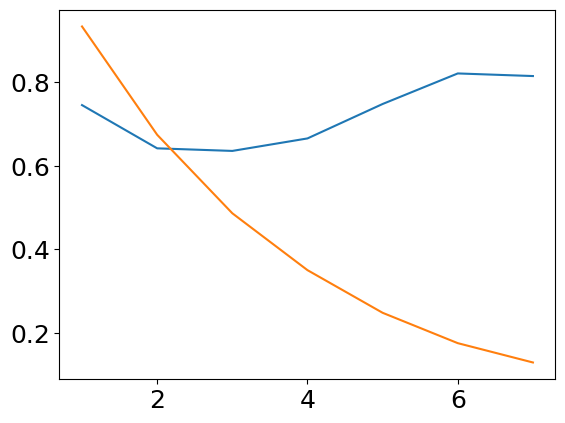

### Illustrate learning rate schedule

c:\Users\rldek\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


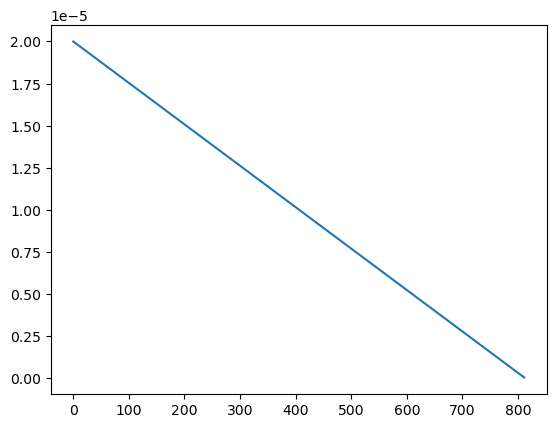

In [79]:
from torch.utils.data import RandomSampler, DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt

model = AutoModelForSequenceClassification.from_pretrained(experiments['bert_base_full']['ckpt'], num_labels=3)

train_sampler = RandomSampler(experiments['bert_base_full']['dataset_enc']['train'])
train_dataloader = DataLoader(experiments['bert_base_full']['dataset_enc']['train'], sampler=train_sampler, batch_size=16)

grad_accum_steps = 1
n_epochs = 7
t_total = len(train_dataloader) // grad_accum_steps * n_epochs

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-6)                                              # $
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0, num_training_steps=t_total) # $

lrs=[]
for i in range(t_total):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()
plt.plot(lrs);